In [18]:
import os
import skimage
from skimage import feature
from skimage import transform
import keras
import numpy as np

import matplotlib.pyplot as plt
import ipywidgets as widgets

import skimage.transform.hough_transform as ht

# Load images
Also contains approximate transform to grayscale (i.e. just take the green channel)

In [20]:
files = os.listdir("images")
imsize = 1024
images = np.zeros((len(files), imsize,imsize))
i = 0
for name in files: 
    tmp = skimage.io.imread(os.path.join("images", name))
    images[i] = transform.resize(tmp, (imsize, imsize), anti_aliasing=True)[:,:,1]

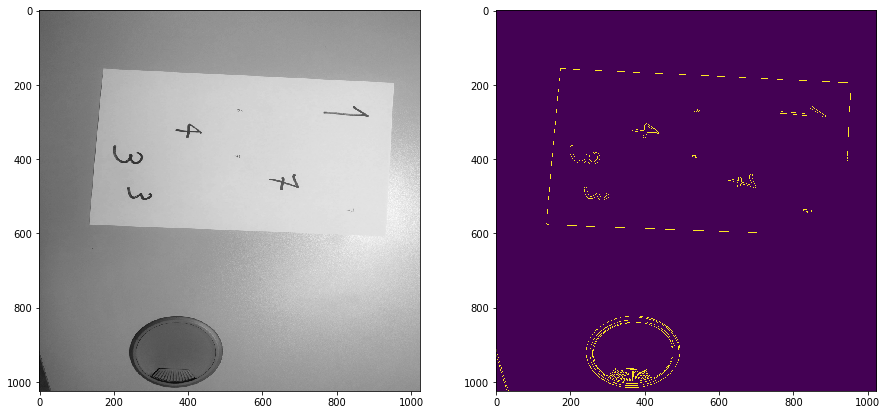

In [26]:
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(images[0], cmap="gray")
ax1.imshow(feature.canny(images[0]))

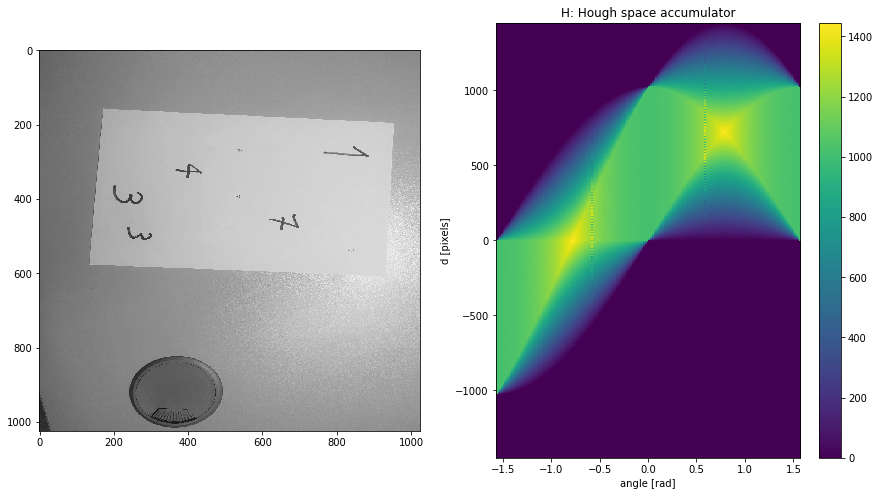

In [13]:

H,angles,distances = ht.hough_line(images[0])
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(images[0], cmap="gray")
Himage = ax1.imshow(H,
                    extent=(angles[0],angles[-1],distances[0],distances[-1]),
                    origin="lower", aspect="auto")
ax1.set(xlabel="angle [rad]",
        ylabel="d [pixels]",
        title="H: Hough space accumulator");
plt.colorbar(Himage)

In [14]:
(maxr, maxc) = np.unravel_index(np.argmax(H), H.shape)
d = distances[maxr]
theta = angles[maxc]
print(d,theta)

3.5012081463582945 -0.7810104641605911


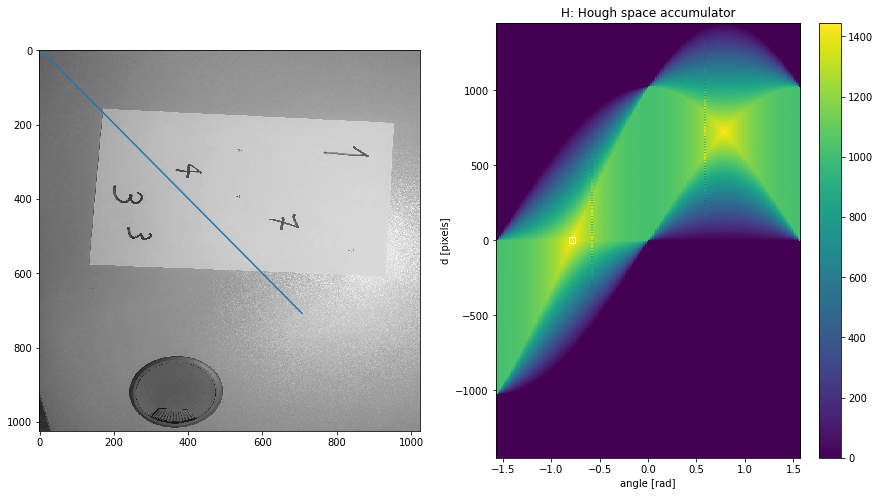

In [16]:
# Same figure as before...
fig,(ax0,ax1) = plt.subplots(ncols=2, nrows=1, figsize=(15,8))
ax0.imshow(images[0], cmap="gray")
Himage = ax1.imshow(H,extent=(angles[0],angles[-1],distances[0],distances[-1]),origin="lower",aspect="auto")
ax1.set(xlabel="angle [rad]",
        ylabel="d [pixels]",
        title="H: Hough space accumulator");
plt.colorbar(Himage)

# Plot a white rectangle over the maximum
ax1.plot(theta, d, "ws", fillstyle="none")

## Now we want to draw the line in image space
# This is one point on the line
p1 = np.array([d*np.cos(theta), d*np.sin(theta)])
# This is the unit vector pointing in the direction of the line (remember what theta means in Hough space!)
linedir = np.array([np.cos(theta+np.pi/2), np.sin(theta+np.pi/2)])
# These are two points very far away in two opposite directions along the line
p0 = p1 - linedir * 1000
p2 = p1 + linedir * 1000
# We now draw a line through p0 and p2, without rescaling the axes.
ax0.plot([p0[0],p2[0]],[p0[1],p2[1]], scalex=False, scaley=False)